In [1]:
import numpy as np 
from matplotlib import pyplot as plt

# To render plots inside the Jupyter notebook
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

The [Kozai mechanicsm](https://en.wikipedia.org/wiki/Kozai_mechanism) or the *Lidov-Kozai* 
mechanism is a phenomenon in hierarchical triple systems in which a distant inclined perturber modifies
the orbit of an inner binary. 
If we work in Jacobi coordinates, we have **3 bodies** and **two interacting orbits**.
We denote the semi-major axis of the inner orbit by $a_1$ and the semi-major axis of the outer
orbit (the perturber) with respect to the centre of mass of the inner binary by $a_2$. 
The energy of each orbit $E=-Gm_1m_2/a$ is a approximately conserved for each of the
two orbits but the system evolves by angular momentum exchange between the two orbits.
Kozai (1962) showed that if you write down the Hamiltonian for this 3-body problem
under the assumption that the second body is a massless test particle 
and expand it into a series to 2nd order in the semi-major axis ratio $(a_1/a_2)$ (which
is small because the perturber is distant); the inner test particle's eccentricity and
inclination will oscillate on timescales much longer than the orbital timescales if the
mutual inclination of the two orbits is greater than $39.2^\circ$.
The Kozai mechanics is seen all over astrophysics, it explains the inclination distribution of Jupiter's
irregular satellites and Kuiper belt objects, it is one of the mechanisms enabling black hole mergers
(implications for LIGO and gravitational wave detection) and it plays a role in sculpting a
variety of exoplanet systems.

# Case 1: one of the two inner bodies is massless (test particle), circular perturber

Let's first consider the case in the original paper by Kozai, where one of the inner two
particles is massless and, the eccentricity of the perturber $e_2$ is zero and we're to
quadropole order in eccentricity.
Under these approximations, one can show that that the argument of pericentre of the inner body $\omega_1$ 
librates (slowly varies) around either $0^\circ$ or $180^\circ$ and there is a conserved quantity
$j_z=\sqrt{1-e_1^2}\cos (i_2-i_1)=\mathrm{const.}$ which is the $z$ component of the first orbit's angular momentum projected onto the angular momentum of the 2nd orbit (the perturber). 
The conservation of this quantity implies that the eccentricity of the test particle and the relative
inclination of the two orbits are coupled and they will oscillate.

### Exercises
1. Set up a system with a test particle in an orbit of a solar mass star and a distant 
massive perturber on an inclined orbit. Integrate the system for some timespan 
which is sufficient to observe the Kozai effect. Save the orbital elements at
each time step.
3. Explore the dependance of the eccentricity oscillations on the initial mutual inclination between
the two orbits, you should see different behaviour of the orbits depending on wether
the initial mutual inclination is greater than or less than about $40^\circ$. What happens
as the mutual inclination approaches $90^\circ$?
5. Plot the argument of pericentre $\omega_1$ as a function of time, does it librate or oscillate? 
6. Check how your results change depending on wether you use the `whfast` or `mercurius` integrator. If they give
different results, think about why that might happen.

In [2]:
import rebound

def simulate(inc, integrator, tmax):
    """
    Runs a REBOUND simulation of a three body system consisting of a 
    a star, a test particle and an inclined perturber and plots the
    relevant orbital parameters.
    
    Parameters
    ----------
    inc : float
        Inclination of the distant perturber, in degrees.
    integrator: str
        The integrator to be used for the simulation. Choose between the 
        symplectic integrator 'whfast' and the hybrid integrator 'mercurius'.
        whfast is much faster but doesn't handle close encounters properly.
    tmax : float
        Max integration time, in years.
    """
    sim = rebound.Simulation()
    sim.add(m=1) 
    sim.add(m=0., e=0., a=1.) 
    sim.add(m=1., e=0., a=10., inc=inc*np.pi/180) 
    sim.move_to_com()
    
    # Set timestep to 5% of inner orbital period
    sim.dt = 0.05*sim.particles[1].P
    sim.integrator = integrator

    N = 1000
    times = np.linspace(0., tmax*2*np.pi, N) 

    # Initialize empty arrays in which we'll store the orbital elements at each time step
    a = np.zeros((2, N))
    e = np.zeros((2, N))
    inc = np.zeros((2, N))
    omega = np.zeros((2, N))

    # Iterate over all times in the array and integrate the system forward by dt
    for i,t in enumerate(times):
        sim.integrate(t, exact_finish_time=0)
        for j, particle in enumerate(sim.particles[1:]): 
            orbit = particle.calculate_orbit()
            a[j, i] = orbit.a
            e[j, i] = orbit.e
            inc[j, i] = orbit.inc
            omega[j, i] = orbit.omega
            
    # Plot the relevant orbital elements
    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    ax[0].plot(times/1e3, e[0, :], 'C0.', label=r'$e_1$')
    ax[0].plot(times/1e3, e[1, :], 'C1.', label=r'$e_2$')
    ax[1].plot(times/1e3, (inc[1, :] - inc[0, :])*180/np.pi, 'C0.')
    ax[2].plot(times/1e3, (inc[1, :] - omega[0, :])*180/np.pi, 'C0.')

    ax[2].set_xlabel('time [thousands of years]')
    ax[0].set_ylabel('eccentricity')
    ax[1].set_ylabel('$\Delta I$ [deg]')
    ax[2].set_ylabel('$\Delta\omega$ [deg]')

    for a in ax.ravel():
        a.grid()
        a.legend()

Let's simulate the system consisting of a test particle at 1 AU and a companion star at 10 AU at a low 
inclination of 20 degrees.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


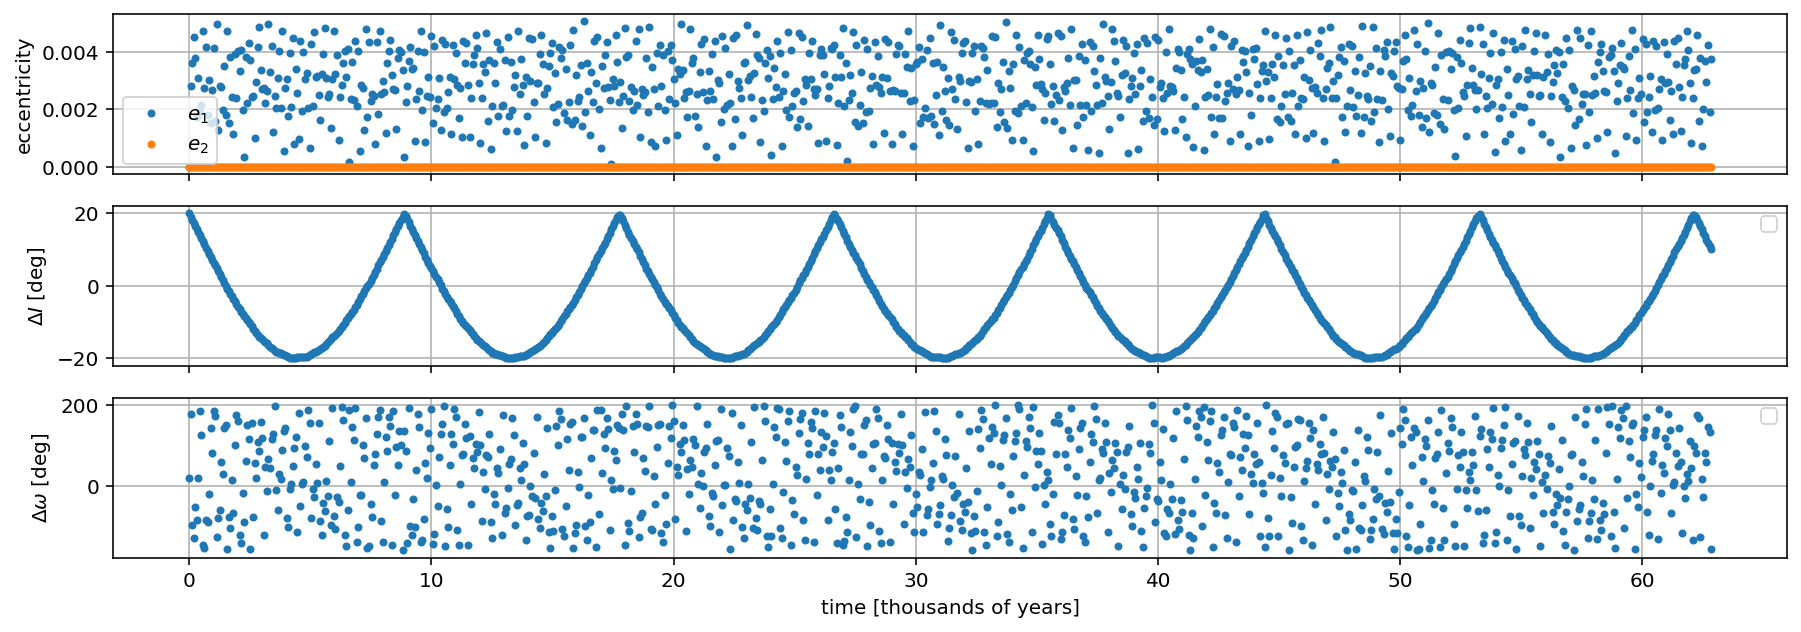

In [3]:
simulate(20., "whfast", 1e4)

Nothing interesting is going on, the orbit of the planet is nearly circular, the argument of pericentre is circulating.
Let's see what happens when we increase the inclination to 45 degrees.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


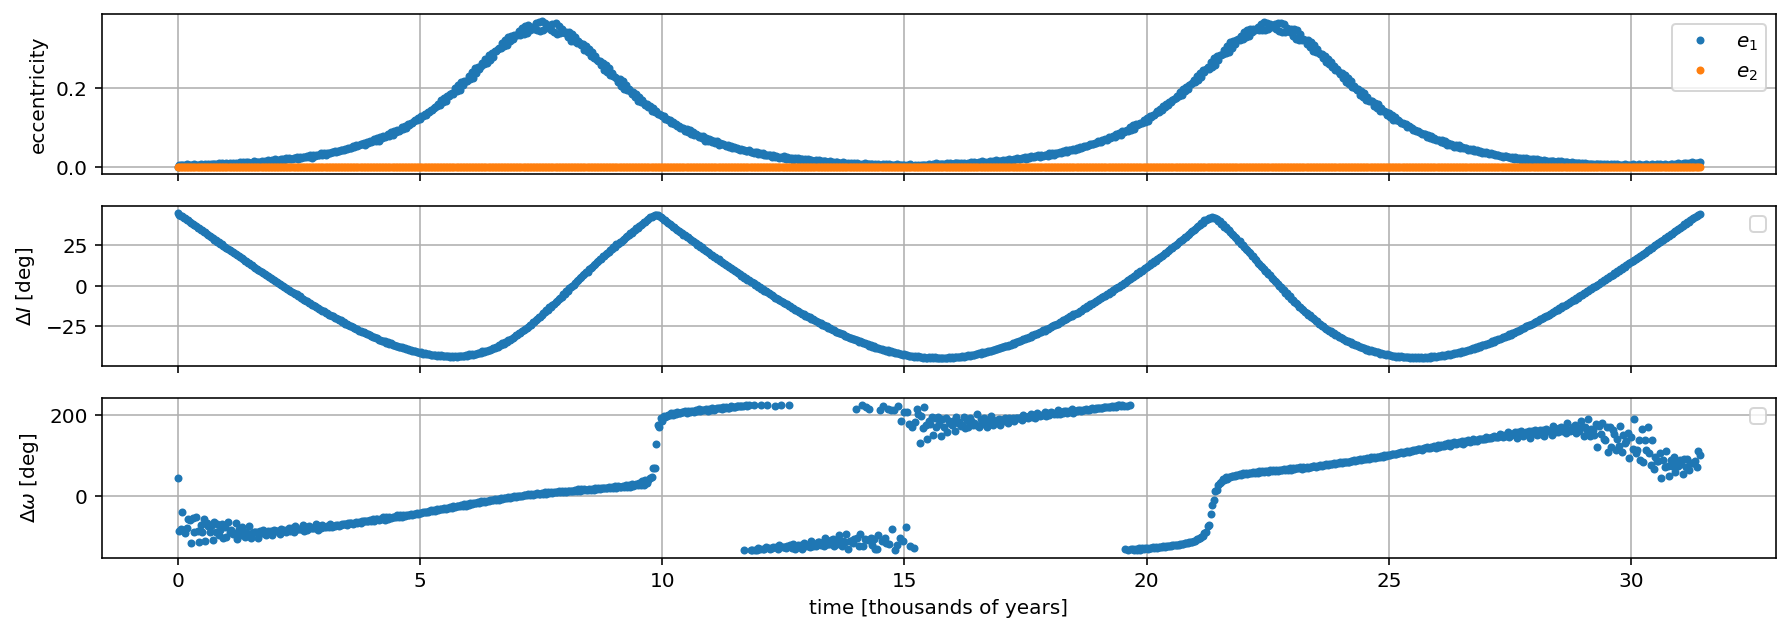

In [4]:
simulate(45., "whfast", 5e3)

A lot more interesting, the eccentricity of the test particle oscillates with a period of about 10k years reaching
values as high as $\sim 0.3$. We also see that that argument of pericentre no longer oscillates between $-180^\circ$ and
$180^\circ$ but rather it librates around specific values.

Let's see what happens if we crank up the inclination to nearly 90 degrees.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


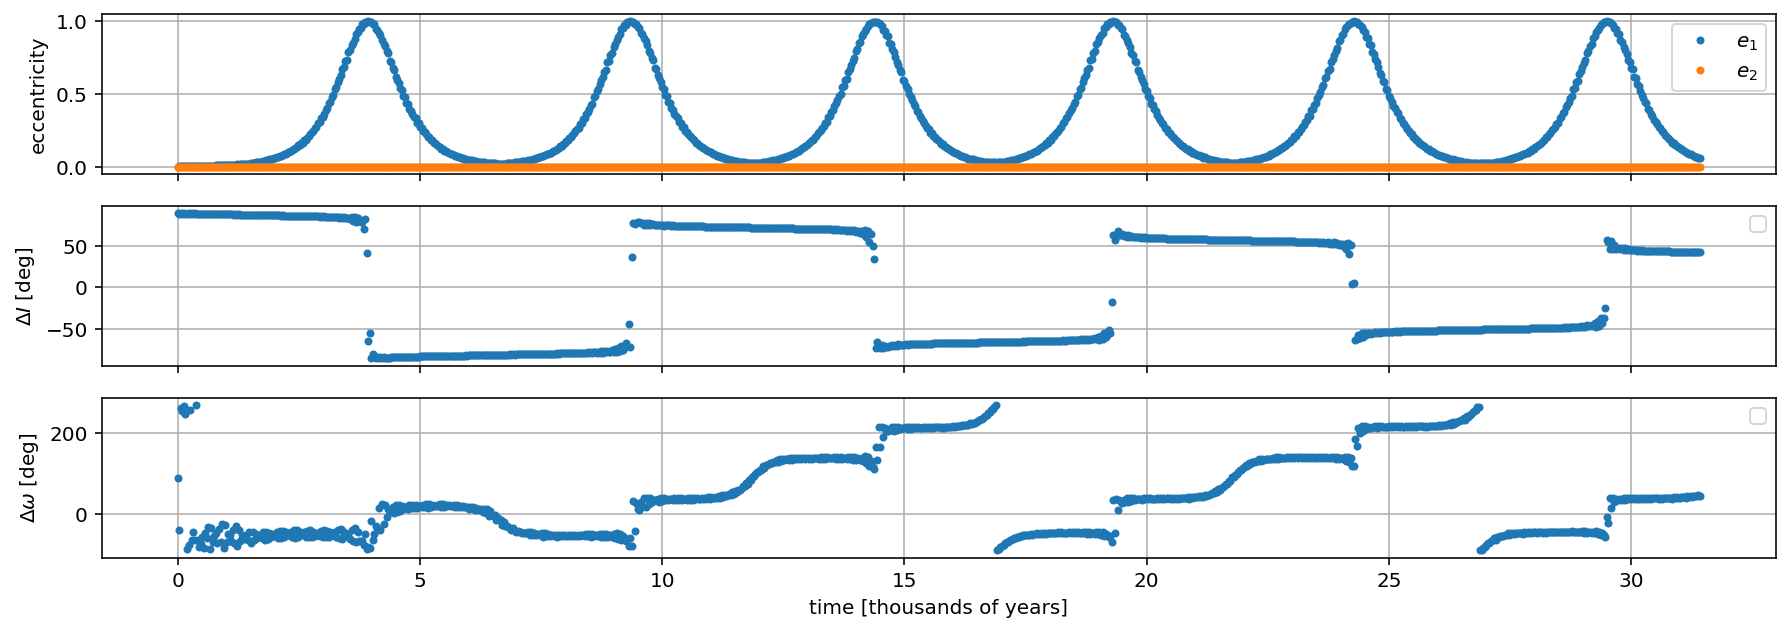

In [5]:
simulate(89., "whfast", 5e3)

The eccentricity oscillations reach near unity since  at those points the test particle comes very close to the
star, it is unlikely that `whfast` integrator is giving accurate results, let's switch the integrator to
a higher precision hybrid integrator `mercurius` and see what happens.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


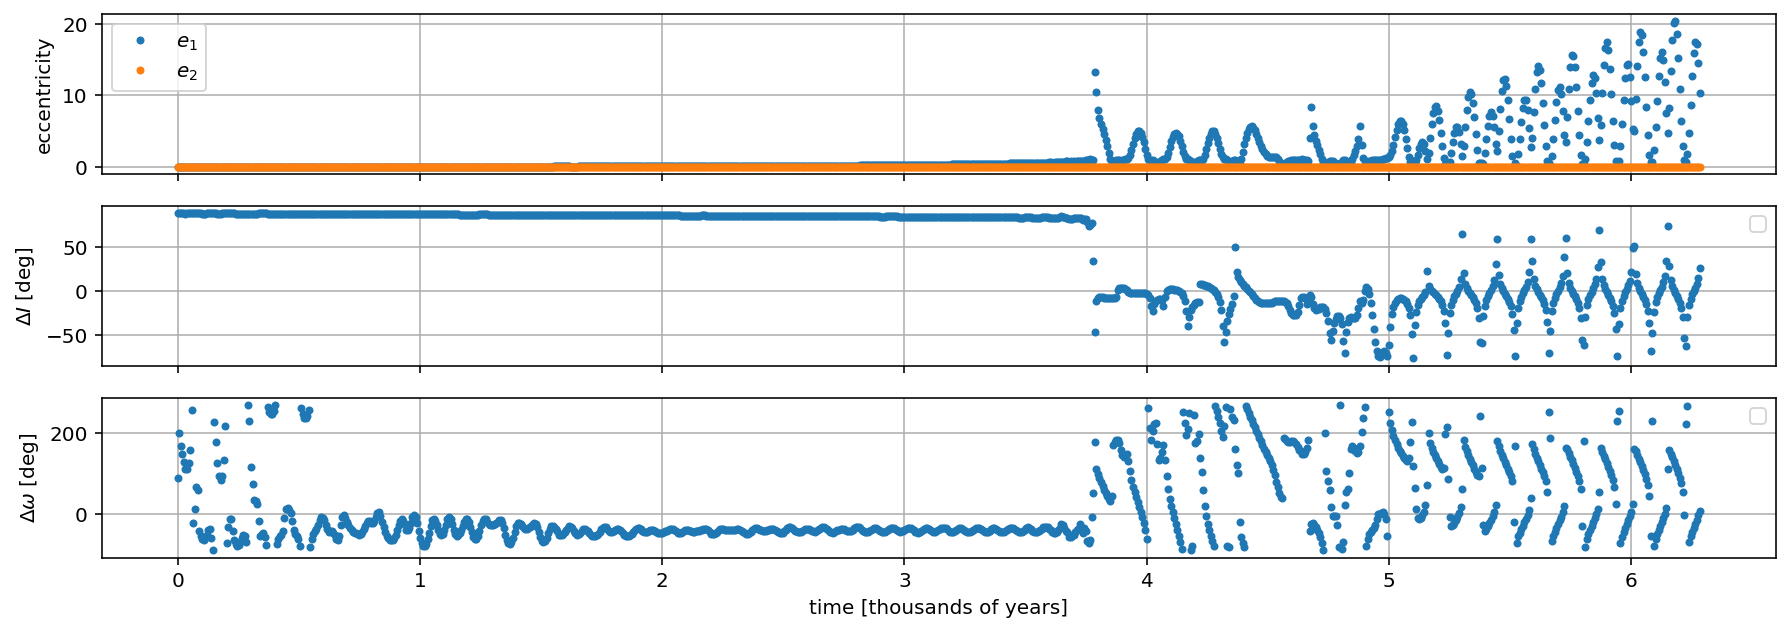

In [6]:
simulate(89., "mercurius", 1e3)

Unsurprisingly, as soon as the eccentricity of the test particle starts approaching unity, the particle gets ejected.

# Case 2: Simulating the exoplanet HD 80606 b  

The exoplanet [HD 80606](http://www.openexoplanetcatalogue.com/planet/HD%2080606%20b/)
is a transiting Hot Jupiter with a mass four times that of Jupiter and an extremely eccentric ($e=0.9336$) and
close-in ($a=0.453$ AU) orbit. 
The extremely eccentric orbit is thought to be a result of a distant inclined stellar companion driving 
the eccentricity through the Kozai effect. Indeed, the star HD 80606 is a binary star with the secondary 
orbiting the primary at around $a=1000$ AU. To test the plausibility of the Kozai hypothesis, we'll 
simulate the system using REBOUND.

### Exercises:
1. Set up a system with a $1 M_\odot$ star, a mildly eccentric planet with mass $4M_{J}$ at 5 AU 
and a highly inclined distant stellar companion of mass $1.2 M\odot$ at $\sim 10000$ AU. Can you drive 
the eccentricity of the planet to near unity? (Hint: use the `whfast` integrator and integrate the system for
a long time).
2. The observed planet is at $\sim 0.5$ AU, what physical mechanism can reduce the semi-major 
axis of the planet in combination with the Kozai effect to such low values? How can you simulate this
mechanism with REBOUND?

In [8]:
sim = rebound.Simulation()

m_jupiter = 0.000954265748 # solar masses

# semi-major axis
a1 = 5.
a2 = 1000.

# eccentricity
e1 = 0.1
e2 = 0.7

# inclination
inc2 = 85*np.pi/180

# masses
m = 1.
m1 = 3.94*m_jupiter
m2 = 1.1

sim.add(m=m) # star 1
sim.add(m=m1, e=e1, a=a1) # planet
sim.add(m=m2, e=e2, a=a2, inc=inc2) # star 2
sim.move_to_com()

sim.status() # get info on all particles in the simulation

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jul  9 2019 15:23:25
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=-156.87886961202338 y=0.0 z=0.0 vx=0.0 vy=-0.006831116636980089 vz=-0.05687254561937933>
<rebound.Particle object, m=0.0037598070471199997 x=-152.37886961202338 y=0.0 z=0.0 vx=0.0 vy=0.4885106930149976 vz=-0.05687254561937933>
<rebound.Particle object, m=1.1 x=143.1379861452935 y=0.0 z=0.0 vx=0.0 vy=0.004540373355262569 vz=0.0518967049247152>
---------------------------------


In [9]:
sim.dt = 0.05*sim.particles[1].P

sim.integrator = "whfast"

N = 1000
tmax = 1e7*(2*np.pi)
times = np.linspace(0., tmax, N) 

# Initialize empty arrays in which we'll store the orbital elements at each time step
a = np.zeros((2, N))
e = np.zeros((2, N))
inc = np.zeros((2, N))
omega = np.zeros((2, N))
Omega = np.zeros((2, N))

# Iterate over all times in the array and integrate the system forward by dt
for i,t in enumerate(times):
    sim.integrate(t, exact_finish_time=0)
    for j, particle in enumerate(sim.particles[1:]): 
        orbit = particle.calculate_orbit()
        a[j, i] = orbit.a
        e[j, i] = orbit.e
        inc[j, i] = orbit.inc
        omega[j, i] = orbit.omega
        Omega[j, i] = orbit.Omega

No handles with labels found to put in legend.
No handles with labels found to put in legend.


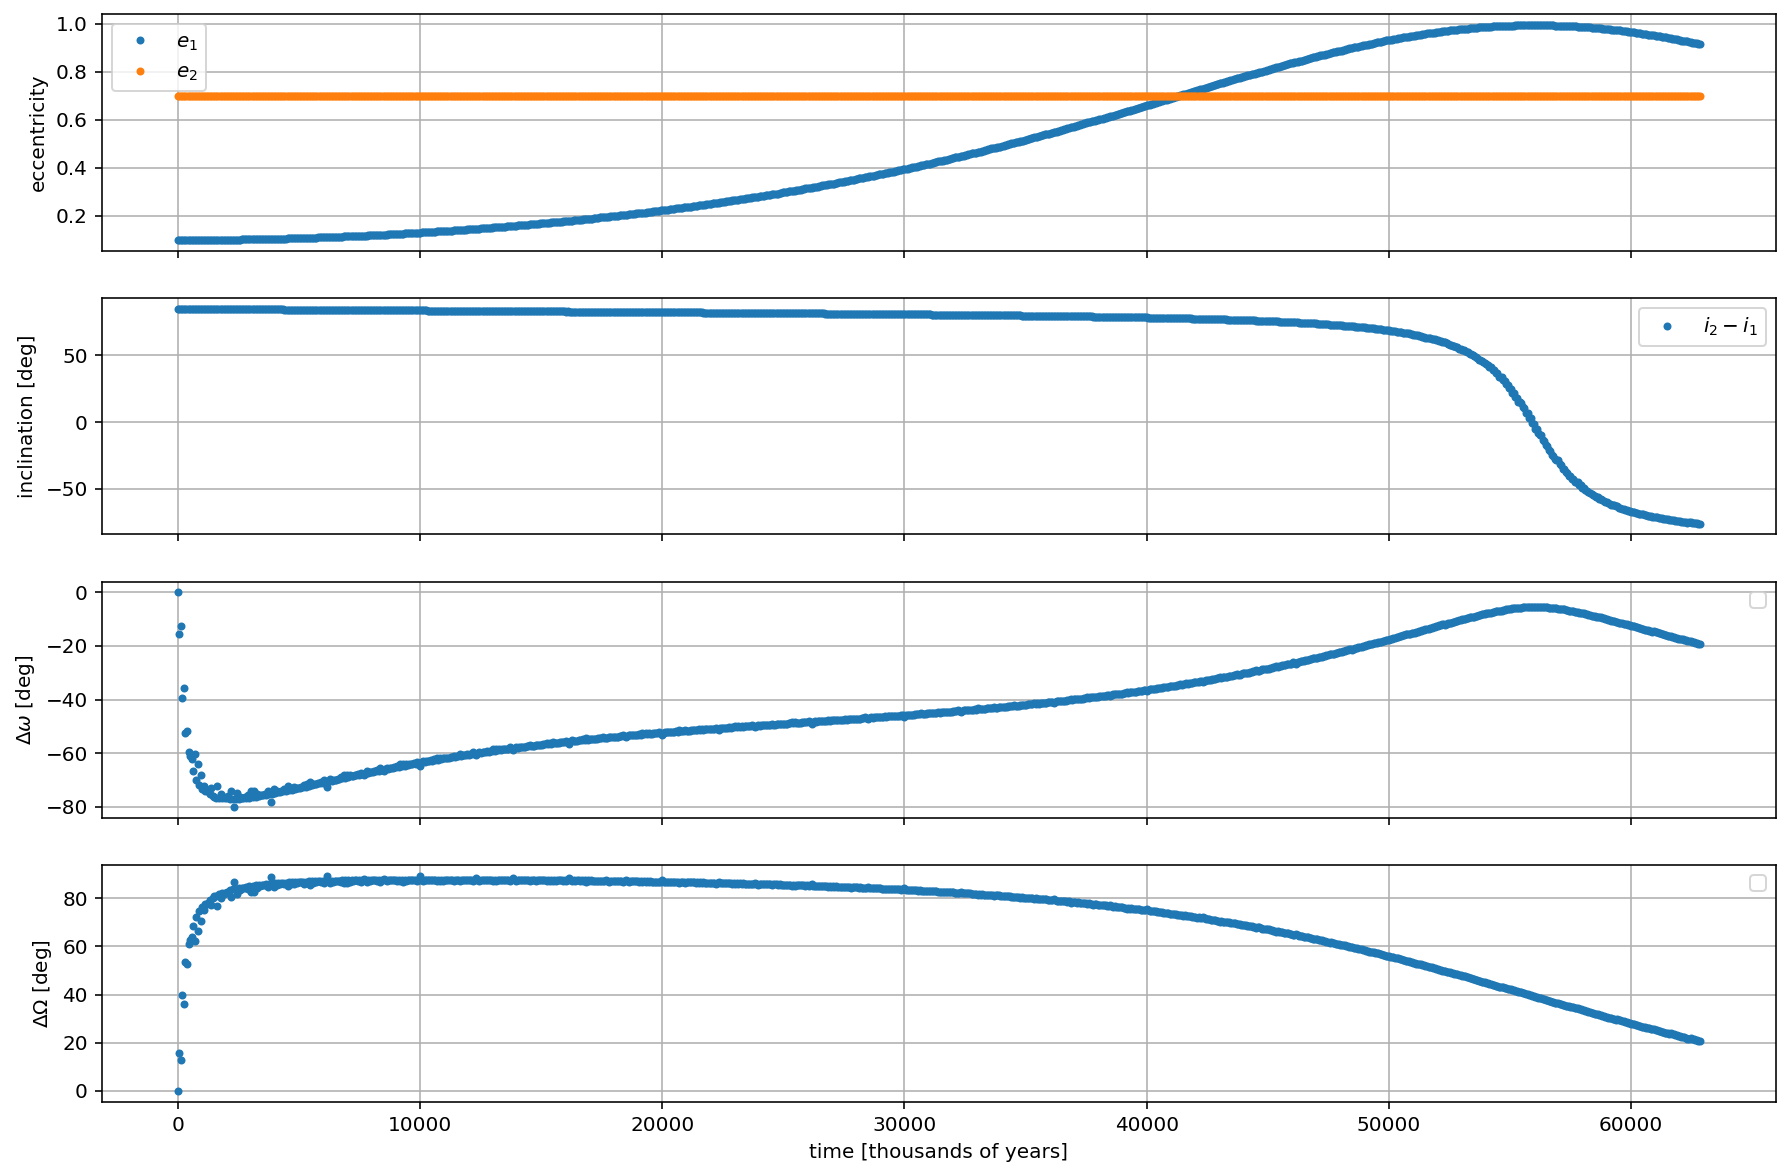

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax[0].plot(times/1e3, e[0, :], 'C0.', label=r'$e_1$')
ax[0].plot(times/1e3, e[1, :], 'C1.', label=r'$e_2$')
ax[1].plot(times/1e3, (inc[1, :] - inc[0, :])*180/np.pi, 'C0.', label=r'$i_2 - i_1$')
ax[2].plot(times/1e3, (omega[0, :] - omega[1, :])*180/np.pi, 'C0.')
ax[3].plot(times/1e3, (Omega[0, :] - Omega[1, :])*180/np.pi, 'C0.')

ax[3].set_xlabel('time [thousands of years]')
ax[0].set_ylabel('eccentricity')
ax[1].set_ylabel('inclination [deg]')
ax[2].set_ylabel('$\Delta\omega$ [deg]')
ax[3].set_ylabel('$\Delta\Omega$ [deg]')

for a in ax.ravel():
    a.grid()
    a.legend()